Import census and related packages for spatial analysis

In [12]:
import cellxgene_census
import tiledbsoma
import spatialdata as sd
import spatialdata_plot

import warnings
warnings.filterwarnings("ignore")

In [13]:
#versions of required libraries for this tutorial
print("cellxgene_census",cellxgene_census.__version__)
print("tiledbsoma", tiledbsoma.__version__)
print("spatialdata", sd.__version__)
print("spatialdata plot", spatialdata_plot.__version__)

cellxgene_census 1.16.2
tiledbsoma 1.15.6
spatialdata 0.3.0
spatialdata plot 0.2.9


We can find Census level metadata in the census_info slot. In this slot we can also view a complete list of datasets in this release of the census - note the inclusion of spatial datasets in the sample data table printed below. Additionally, we can print out the keys associated with the census_spatial_sequencing slot giving us access to Visium and Slide seq V2 assays performed in either mouse or human. Also note that for spatial data within census, we make no normalized expression data layer available.

In [14]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    #Print Census level metadata
    print("Census level metadata\n")
    print(list(census["census_info"].keys()))

    print("\n")

    print("Census datasets info\n")
    print(census["census_info"]["datasets"].read().concat().to_pandas().head())

    print("\n")

    print("Census spatial keys\n")
    print(list(census["census_spatial_sequencing"].keys()))

    #[optional] not run - spatial data obs metadata table
    #print(census["census_spatial_sequencing"]["homo_sapiens"]["obs"].read().concat().to_pandas().head())

    #[optional] not run - spatial data var metadata table
    #print(census["census_spatial_sequencing"]["homo_sapiens"]["ms"]["RNA"]["var"].read().concat().to_pandas().head())

Census level metadata

['datasets', 'organisms', 'summary', 'summary_cell_counts']


Census datasets info

   soma_joinid                                           citation  \
0            0  Publication: https://doi.org/10.1016/j.isci.20...   
1            1  Publication: https://doi.org/10.1016/j.isci.20...   
2            2  Publication: https://doi.org/10.1016/j.isci.20...   
3            3  Publication: https://doi.org/10.1016/j.isci.20...   
4            4  Publication: https://doi.org/10.1038/s41591-02...   

                          collection_id  \
0  8e880741-bf9a-4c8e-9227-934204631d2a   
1  8e880741-bf9a-4c8e-9227-934204631d2a   
2  8e880741-bf9a-4c8e-9227-934204631d2a   
3  8e880741-bf9a-4c8e-9227-934204631d2a   
4  a96133de-e951-4e2d-ace6-59db8b3bfb1d   

                                     collection_name  \
0  High Resolution Slide-seqV2 Spatial Transcript...   
1  High Resolution Slide-seqV2 Spatial Transcript...   
2  High Resolution Slide-seqV2 Spatial Transcript..

# Query the Census Spatial Sequencing object

This example demonstrates how to query spatial single-cell data from the CELLxGENE Census. We extract metadata for human cells that match specific criteria, such as sex and cell type. Here’s what the code does:

Open the Census: Access the dataset for the latest build, dated 2025-01-21.
Filter the Data: Select cells labeled as “female” and of types “microglial cell” or “neuron.”
Retrieve Metadata: Specify which metadata columns to include in the results.
Process the Output: Convert the filtered data into a pandas DataFrame for further analysis.
The resulting DataFrame contains the metadata for the filtered subset, ready for exploration or downstream use.

In [15]:
## perform queries
with cellxgene_census.open_soma(census_version="latest") as census:

    # Reads SOMADataFrame as a slice
    cell_metadata = census["census_spatial_sequencing"]["homo_sapiens"].obs.read(
        value_filter = "sex == 'female' and cell_type in ['microglial cell', 'neuron']",
        column_names = ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease"]
    )

    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

    print(cell_metadata)

                             assay cell_type tissue tissue_general  \
0                      Slide-seqV2    neuron  liver          liver   
1                      Slide-seqV2    neuron  liver          liver   
2                      Slide-seqV2    neuron  liver          liver   
3                      Slide-seqV2    neuron  liver          liver   
4                      Slide-seqV2    neuron  liver          liver   
..                             ...       ...    ...            ...   
72                     Slide-seqV2    neuron  liver          liver   
73                     Slide-seqV2    neuron  liver          liver   
74  Visium Spatial Gene Expression    neuron   lung           lung   
75  Visium Spatial Gene Expression    neuron   lung           lung   
76  Visium Spatial Gene Expression    neuron   lung           lung   

   suspension_type        disease     sex  
0               na  breast cancer  female  
1               na  breast cancer  female  
2               na  breast 

# Spatial Data Export

We can export our data to a SpatialData object (see documentation here for more information), enabling us to visualize and analyze it. In the next block, we query the human experiment in the census. With axis_query, we can set a filter using the obs_query argument, where we can specify which spatial slide(s) to return. Note that we demonstrates an alternative to filtering based on categorical metadata, as shown earlier. This approach will return only a single slide corresponding to the dataset we have identified. You can find After the query has been formed, we can use the to_spatialdata method to export our filtered data to the spatialdata format.

In [16]:
## export to spatialdata

census = cellxgene_census.open_soma(census_version="2025-01-30") # similar to the query above, but without the context manager

exp = census["census_spatial_sequencing"]["homo_sapiens"]

# alternative way to perform query with tiledbsoma instead of cellxgene_census
with exp.axis_query(
    measurement_name="RNA",
    obs_query=tiledbsoma.AxisQuery(value_filter="dataset_id == '4cceac62-9513-42a4-90e5-2878dbb0192c'") # query specific dataset instead of by obs metadata
) as query:
    sdata = query.to_spatialdata(X_name="raw")


In the cells below, we explore the structure of the resulting SpatialData object. You can find a more detailed description of the SpatialData definition here. Note that in our current example we have only exported a single dataset, however in the scenario where multiple datasets (slides) match your query - all of those slides will be stored as different “scenes” within the SpatialData object. The corresponding assets for each scene will be distinguished by the prepended UUID (i.e. in this example, 4cceac62-9513-42a4-90e5-2878dbb0192c, refers to the dataset UUID).

In [17]:
sdata

SpatialData object
├── Images
│     └── '4cceac62-9513-42a4-90e5-2878dbb0192c_library': DataArray[cyx] (3, 1862, 2000)
├── Shapes
│     └── '4cceac62-9513-42a4-90e5-2878dbb0192c_loc': GeoDataFrame shape: (4992, 3) (2D shapes)
└── Tables
      └── 'RNA': AnnData (4992, 44405)
with coordinate systems:
    ▸ '4cceac62-9513-42a4-90e5-2878dbb0192c', with elements:
        4cceac62-9513-42a4-90e5-2878dbb0192c_library (Images), 4cceac62-9513-42a4-90e5-2878dbb0192c_loc (Shapes)

Expression data is stored within an AnnData object within the SpatialData object, where you can also find relevant observation metadata in obs and variable metadata in var.

In [18]:
sdata.tables

{'RNA': AnnData object with n_obs × n_vars = 4992 × 44405
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'in_tissue', 'array_row', 'array_col', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'region_key', 'instance_key'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'spatialdata_attrs'}

If we take a quick look at the expression data for this spatial slide, we can see that by default, the SpatialData object exported from the Census has a set of soma_joinid’s as the default index in var. This index is what will be referred to when we try to plot genes in the next section, so we need to set the index to feature_name in order to enable plotting by gene symbols.

In [19]:
sdata["RNA"].var.head()

,soma_joinid,feature_id,feature_name,feature_type,feature_length,nnz,n_measured_obs
0,0,ENSG00000121410,A1BG,protein_coding,2134,156783,2793392
1,1,ENSG00000268895,A1BG-AS1,lncRNA,1667,20214,2954787
2,2,ENSG00000148584,A1CF,protein_coding,2211,41417,2852627
3,3,ENSG00000175899,A2M,protein_coding,590,783018,2967531
4,4,ENSG00000245105,A2M-AS1,lncRNA,2551,10592,2877056


In [20]:
#set index of var dataframe for the expression data
sdata.tables["RNA"].var.set_index("feature_name", inplace=True)

Note that our index has changed to consist of gene symbols and we can now use the SpatialData plotting API to plot by our genes of interest.

In [21]:
sdata["RNA"].var.head()

,soma_joinid,feature_id,feature_type,feature_length,nnz,n_measured_obs
feature_name,,,,,,
A1BG,0,ENSG00000121410,protein_coding,2134,156783,2793392
A1BG-AS1,1,ENSG00000268895,lncRNA,1667,20214,2954787
A1CF,2,ENSG00000148584,protein_coding,2211,41417,2852627
A2M,3,ENSG00000175899,protein_coding,590,783018,2967531
A2M-AS1,4,ENSG00000245105,lncRNA,2551,10592,2877056


# Plotting Continuous Metadata

We can plot expression data over our tissue image from our exported SpatialData object. We can specify various spatial embedding metadata to overlay on the tissue image. Here we plot gene expression of MALAT1, a continuous metadata field.

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.008].


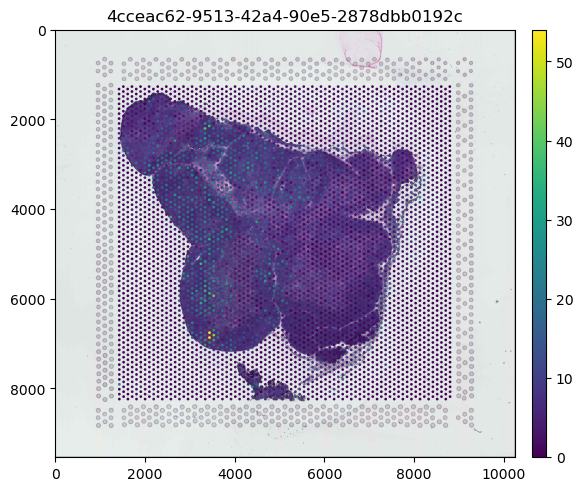

In [22]:
(
    sdata.pl.render_images()
    .pl.render_shapes(color="MALAT1")
    .pl.show()
)

# Plotting Categorical Metadata

Below, we will overlay categorical information (cell_type) on our tissue image. When exporting data from the Census, categorical metadata stored in the obs DataFrame is represented as a pandas categorical series.

Since this DataFrame is a subset of the original metadata, its categories still include all possible values from the full Census dataset—even if they are not present in our exported slice of data. This can cause issues when plotting, such as difficulty in automatically assigning a suitable color palette.

To resolve this, we will remove unused categories from the cell_type column before visualization.

In [23]:
# Print number of categories before resetting
print("Before:", len(sdata["RNA"].obs["cell_type"].cat.categories))

# Remove unused categories
sdata["RNA"].obs["cell_type"] = sdata["RNA"].obs["cell_type"].cat.remove_unused_categories()

# Print number of categories after resetting
print("After:", len(sdata["RNA"].obs["cell_type"].cat.categories))

Before: 228
After: 7


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.008].


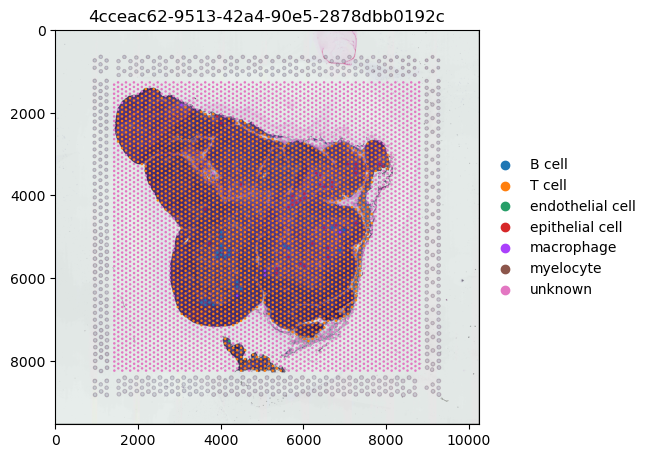

In [24]:
(
    sdata.pl.render_images()
    .pl.render_shapes(color="cell_type")
    .pl.show()
)